# Spam vs Ham Email Classifier

## Introduction
We will utilize Logistic Regression to create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails.

This project allowed me to practice the following:

- Feature engineering with text data.
- Using the `sklearn` library to process data and fit classification models.
- Validating the performance of your model
- Conducting Principal Component Analysis for dimensionality reduction minimizing overfitting.
- Generating and analyzing ROC curves.

This first part of the project focuses on initial analysis, feature engineering, and logistic regression. In the second part of this project we built our own spam/ham classifier.

## Content Warning
This is a **real-world** dataset —— the emails we are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate.

In [62]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.
The iwut extension is already loaded. To reload it, use:
  %reload_ext iwut


### Initial Import Statements

In [63]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Our labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2024.

The following cells load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data we will use to train your model. It has four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails.

In [64]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [65]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


<br/>

First, let's check if our data contains any missing values. The cell below prints the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [66]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [67]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



<!-- BEGIN QUESTION -->

---
## Some things we initially noticed between the two emails


We immediately noticed that with the spam email, there are a lot of HTML tags associated with it. If it is common that spam emails contain loads of HTML tags, we could possible use them to classify if an email is a spam, or a ham. 

<!-- END QUESTION -->

## Training-Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, need to split the training data into separate training and validation datasets. We will use this **validation data** to assess the performance of our classifier once we are finished training. Note that we set the seed (`random_state`) to 42. This will produce a pseudo-random sequence of random numbers that is the same each time.

In [68]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.15, random_state = 42)
train, test = train_test_split(train, test_size = 0.15, random_state = 42)

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Feature Engineering

We want to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data is text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll go through creating some simple feature, and then create more interesting ones as we try to increase the accuracy of our model.

<br>

---

Here we create a function `words_in_texts` that takes in a list of interesting words (`words`) and a `Series` of emails (`texts`). Our goal is to check if each word in `words` is contained in the emails in `texts`.

The `words_in_texts` function outputs a **2-dimensional `NumPy` array** that contains one row for each email in `texts` and one column for each word in `words`. If the $j$-th word in `words` is present at least once in the $i$-th email in `texts`, the output array should have a value of 1 at the position $(i, j)$. Otherwise, if the $j$-th word is not present in the $i$-th email, the value at $(i, j)$ should be 0.

Later, we will be applying `words_in_texts` to some large datasets, so implementing some form of vectorization (for example, using `NumPy` arrays, `Series.str` functions, etc.) is most optimal.

For example:
```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

Importantly, we **do not** calculate the *number of occurrences* of each word; only if the word is present at least *once*. 

In [69]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """

    indicator_array = np.array([texts.str.contains(word) for word in words]).astype(int).T
    return indicator_array

In [70]:
# Run this cell to see what your function outputs. Compare the results to the example provided above.
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. Suppose the feature is a binary indicator, such as whether a particular word occurs in the text. In that case, this compares the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. The bars colored by email class were generated by setting the `hue` parameter of `sns.barplot` to a column containing the class (spam or ham) of each data point. An example of how this class column was created is shown below:

![training conditional proportions](images/training_conditional_proportions.png)

You can use `DataFrame`'s `.melt` ([documentation](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.melt.html)) method to "unpivot" a `DataFrame`. See the following code cell for an example.

In [71]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column."))
display(df.melt("type"))

> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<br>

---

Now we will go about creating the bar chart above by comparing the proportion of spam and ham emails containing a specific set of 6 words. These words have different proportions for the two classes (i.e., noticeably different bar heights across spam and ham). Here we're only considering emails from `train`.


`sns.barplot` [documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html) was used. A possible data input is given below:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>type</th>      <th>variable</th>      <th>value</th>    </tr>  </thead>  <tbody>    
<tr>      <th>0</th>      <td>Ham</td>      <td>word_1</td>      <td>0.021269</td>    </tr>    
<tr>      <th>1</th>      <td>Ham</td>      <td>word_2</td>      <td>0.101519</td>    </tr>    
<tr>      <th>2</th>      <td>Spam</td>      <td>word_3</td>      <td>0.059160</td>    </tr>    
<tr>      <th>3</th>      <td>Spam</td>      <td>word_2</td>      <td>0.017694</td>    </tr>    
<tr>      <th>4</th>      <td>Ham</td>      <td>word_4</td>      <td>0.013226</td>    </tr>     
<tr>      <th>...</th>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>    
</tbody></table>

<!-- BEGIN QUESTION -->

Create your bar chart in the following cell:

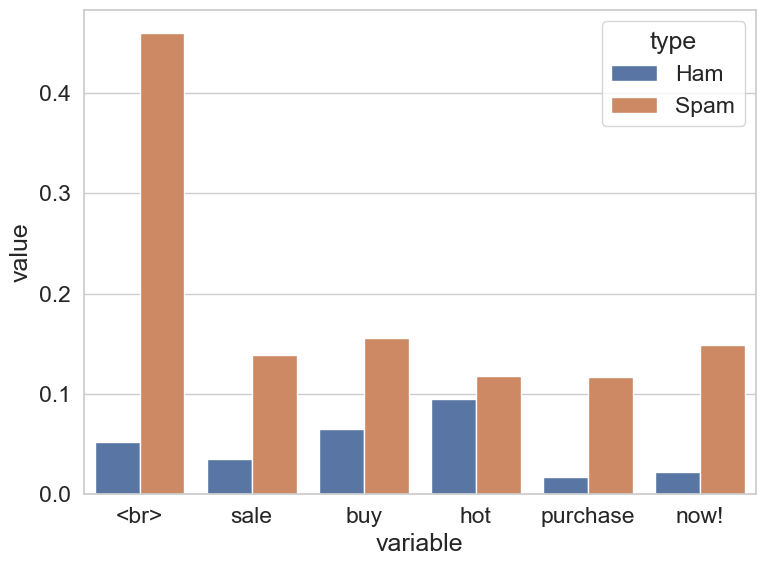

In [72]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))

list_words = ["<br>", "sale", "buy", "hot", "purchase", "now!"]
text_series = train["email"]
words_texts = words_in_texts(list_words, text_series)

df = pd.DataFrame(words_texts)
df.columns = list_words
df["type"] = train["spam"]
grouped = df.groupby("type").agg("mean")
grouped["type"] = pd.Series(["Ham", "Spam"])
grouped = grouped.melt("type")

sns.barplot(data = grouped, x = "variable", y = "value", hue = "type")


plt.tight_layout()
plt.show()

<!-- END QUESTION -->

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous section). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

<br>

---

We're gonna practice with 5 words that might be useful as features to distinguish spam/ham emails. Using these words, along with the `train` `DataFrame`, we create two `NumPy` arrays: `X_train` and `Y_train`. `X_train` is a 2D array of 0s and 1s created using `words_in_texts` function on all the emails in the training set. `Y_train` is a vector of the correct labels for each email in the training set.

In [73]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train["email"])
Y_train = np.array(train["spam"])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([0, 1, 0, 0, 0]))



---
Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, we will train a logistic regression model using `X_train` and `Y_train`. This model's training accuracy is shown below.

In [74]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression()
my_model.fit(X_train, Y_train)

predicted_y = my_model.predict(X_train)

training_accuracy = my_model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7580431177446103


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 5: Evaluating Classifiers

That doesn't seem too shabby! But the classifier above isn't as good as the accuracy would make you believe. First, we are evaluating the accuracy of the model on the training set, which may be a misleading measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will make use of the data we held out for model validation and comparison.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

One quick mnemonic to remember the formulas is that **P**recision involves T**P** and F**P**, Recall does not. 

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help with understanding precision and recall visually:<br />
<center>
<img alt="precision_recall" src="images/precision_recall.png" width="600px" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br>

---

Suppose we have a hypothetical classifier called the “zero predictor.” For any inputted email, the zero predictor *always* predicts 0 (it never makes a prediction of 1 for any email). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? `zero_predictor_fp` is set to the number of false positives and `zero_predictor_fn` the number of false negatives for the hypothetical zero predictor on the training data.

In [75]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)
zero_predictor_fp, zero_predictor_fn

(0, 1538)

<br>

---

What is the accuracy and recall of the zero predictor on the training data? Do not use any `sklearn` functions to compute these performance metrics.

In [76]:
zero_predictor_acc = (len(Y_train) - sum(Y_train))/ len(Y_train)
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7449419568822554, 0)

<!-- BEGIN QUESTION -->

<br>

---
How did we know what to assign to `zero_predictor_fp`, `zero_predictor_fn`, `zero_predictor_acc`, and `zero_predictor_recall`?

For `zero_predictor_fp`, we know to put 0 as since this classifier never outputs any 1s, or in other words, it never outputs any positive values. As a result, the proportion of false positives must inherently be 0. For `zero_predictor_fn`, I put the sum of our Y_train, or the number of original 1's in our training data, as the number of false negatives. This is because since our classifier always outputs 0, then all of the original 1's in the original data will be predicted incorrectly. For `zero_predictor_acc`, I found the number of 0s and divided by the total number of data points. I did this because accuracy is defined as the number of points that were identified correctly. Since this classifier only outputs 0, then the proportion of 0s in the entire training data will also be its accuracy. Finally we have `zero_predictor_recall`. I put 0 here because the formula for recall is the number of true positives / number of predicted positives. However, since our classifier will only ever output 0, there will never be this notion of "true positive", as 1 can never be an output. 

<!-- END QUESTION -->

<br/>

---

Let's now compute the precision, recall, and false positive rate of the `LogisticRegression` classifier from `my_model`. 

In [77]:
Y_train_hat = my_model.predict(X_train)

TP = sum(Y_train_hat + Y_train == 2)
TN = sum(Y_train_hat + Y_train == 0) 
FP = sum(Y_train_hat - Y_train == 1)
FN = sum(Y_train_hat - Y_train == -1)
logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP/ (TP + FN)
logistic_predictor_fpr = FP/ (FP + TN)

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=177, TN=4394, FP=98, FN=1361
logistic_predictor_precision=0.64, logistic_predictor_recall=0.12, logistic_predictor_fpr=0.02


<!-- BEGIN QUESTION -->

<br>

---
How does the accuracy of the logistic regression classifier `my_model` compare to the accuracy of the zero predictor?

They are around the same, with an accuracy for both models being around 0.75. This indicates that the accuracy of `my_model` is essentially the same as if we were strictly classifying each email as not spam. Thus showing how accuracy may not be the best metric in determining how good a classifier is.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

Given the 5 word features provided previously, why could the logistic regression classifier `my_model` could be performing poorly. 

One reason the regression classifier `my_model` is doing so poorly is that we just haven't picked words that are good enough to distinguish between spam or ham. Essentially, this could be happening because most of our words were associated with non-spam emails. There wouldn't be that much of a way to distinguish a spam vs ham email if most of the words we used were associated with non-spam. 

# Building Our Own Model

## Feature Engineering, Classification, and Cross-Validation

In this section of the project, we will build and improve on the concepts and functions we've implemented in the above cells, and finish creating our own classifier to distinguish spam emails from ham (non-spam) emails. 

<br/>
<hr style="border: 1px solid #fdb515;" />

It is now our task to make the spam filter more accurate. Our goal is to get an **85%** accuracy on both the train and validation set. .

Some ideas for improving our model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject/body
    1. Number of words in the subject/body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number/percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. Alternatively, we can identify misclassified emails and see which relevant words are missing in your model.
1. Reducing dimensionality and/or multicollinearity. There are a few methods to achieve this:
    1. Implement PCA.
    1. Interpret the model coefficients. Note that a feature will be more valuable in classification if its coefficient has a larger **absolute** value. If the coefficient has a lower **absolute** value, the feature likely isn't valuable in classifying emails.
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting the text from the HTML to help find better words. Or, we can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust the parameters of your model (e.g. the penalty type, the regularization parameter, or any arguments in `LogisticRegression`) to achieve higher accuracy. 
    1. Consider implementing L1 regularization. The [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for `LogisticRegression` may be helpful here. 
    1. We have imported `GridSearchCV` for you. You may use sklearn's `GridSearchCV` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) class to perform cross-validation. You do not need to code cross-validation from scratch, though you are welcome to do so.

Here's an example of how to use `GridSearchCV`. Suppose we wanted to experiment with 4 different solvers (numerical methods for optimizing the mode) models for a `LogisticRegression` model `lr_model`. 
1. We could define a dictionary specifying the hyperparameters and the specific values we want to try out like so: `parameters = {'solver':[{'lbfgs', 'liblinear', 'newton-cg', 'saga']}`.
2. Running `grid = GridSearchCV(estimator=lr_model, param_grid=parameters)` would give us a model for each combination of hyperparameters we are testing - in this case, just 4 models.
3. We fit each model to some training data `X_train` and `Y_train` using `grid_result = grid.fit(X_train, Y_train)`.
4. Indexing into `grid_result.cv_results_` with a particular metric (in this case, `mean_test_score`), we get an array with the scores corresponding to each of the models. `grid_result.cv_results_['mean_test_score']`.
Feel free to experiment with other hyperparameters and metrics as well. The documentation is your friend!     
       

**Note 1:** You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set. However, you may overfit to your validation set if you try to optimize your validation accuracy too much. Alternatively, you can perform cross-validation on the entire training set.

**Note 2:** If you see a `ConvergenceWarning`, increase the maximum number of iterations the model runs for by passing in a parameter, `max_iter`, into `LogisticRegression()`. This should get rid of the warning. For a longer discussion on why this warning appears, you might find [this StackOverflow post](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter) helpful. Convergence of solvers is not in scope for Data 100, but by understanding what the error messages are saying, you can get some useful context on what to do in these situations.

<br/>
<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

To decide which features to use when building our model, it is helpful to conduct EDA. Some ideas are below:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap` ([documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html))). 
1. Try to show redundancy in a group of features (e.g., `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all HTML tags and compares them to these). 
1. Visualize which words have high or low values for helpful statistics.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

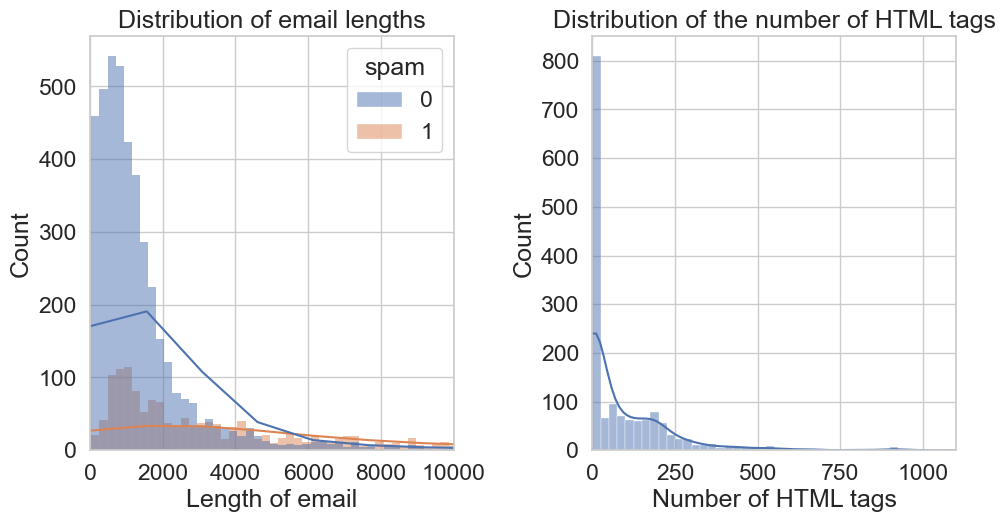

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

train_copy = train.copy()

plt.figure(figsize=(10, 15))

# Plot 1: Distribution of email lengths for spam and ham emails
train_copy["length_email"] = train_copy["email"].apply(len)

plt.subplot(3, 2, 1)  # Use plt.subplot to specify the subplot location
sns.histplot(data=train_copy, x="length_email", hue="spam", kde=True)
plt.xlim(0, 10000)
plt.xlabel("Length of email")
plt.title("Distribution of email lengths")

# Prepare data for the second plot
train_copy_html = train.copy()

def count_HTML_tags(email_contents):
    html_tags = re.findall(r'<[^>]+>', email_contents)
    return len(html_tags)

train_copy_html['html_tag_count'] = train_copy_html['email'].apply(count_HTML_tags)
train_copy_html_spam = train_copy_html[train_copy_html["spam"] == 1]

# Plot 2: Distribution of the number of HTML tags for spam emails
plt.subplot(3, 2, 2)  # Specify the second subplot location
sns.histplot(data=train_copy_html_spam, x="html_tag_count", kde=True)
plt.xlim(0, 1100)
plt.xlabel("Number of HTML tags")
plt.title("Distribution of the number of HTML tags")

# Show the plots
plt.tight_layout()
plt.show()

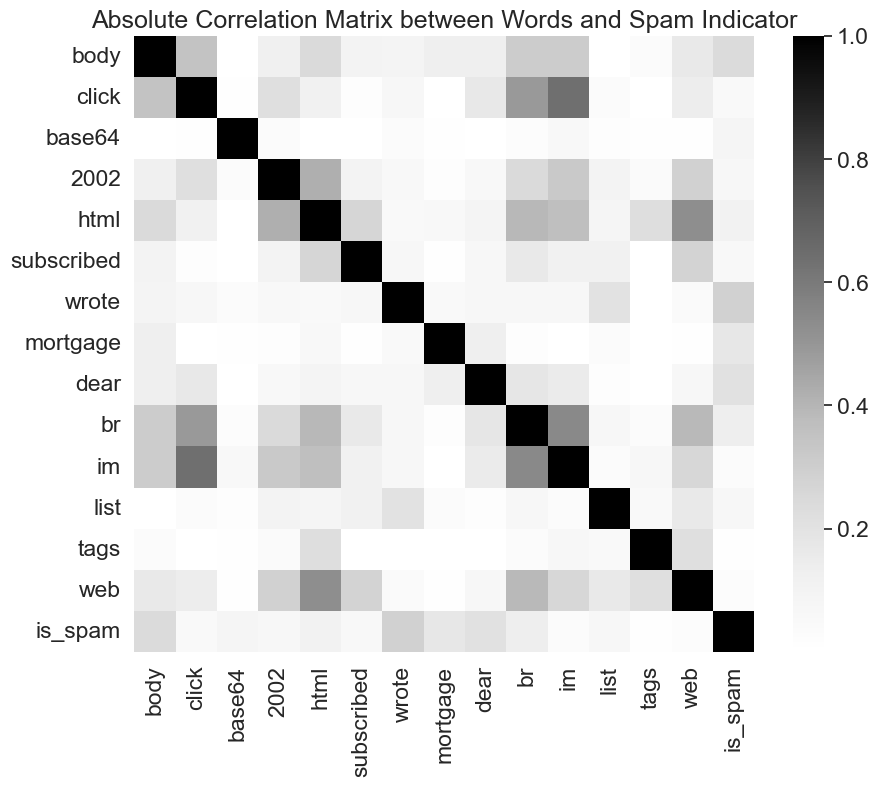

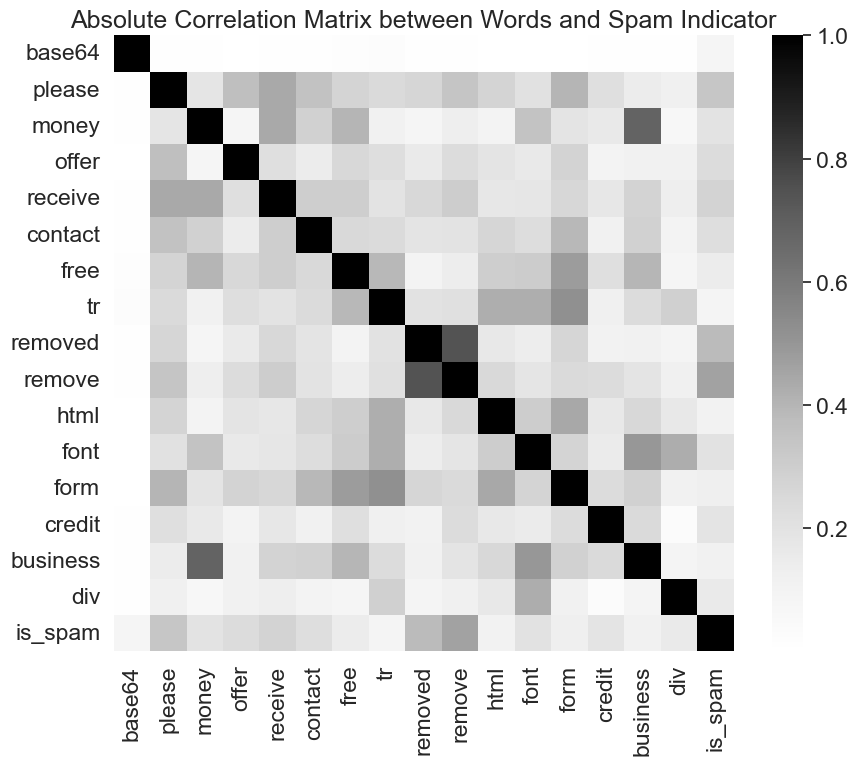

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume train is your DataFrame and words_in_texts is a function you have defined

# First set of spam words
spam_words = ['body', 'click', 'base64', '2002', 'html','subscribed','wrote', 'mortgage', 'dear', 'br', 'im', 'list', 'tags', 'web']

train_spam_words = train.copy()

# First word counts
word_counts = pd.DataFrame(words_in_texts(spam_words, train_spam_words['email']), columns=spam_words)

for word in spam_words:
    word_counts[word] = train_spam_words['email'].str.count(word)

word_counts['is_spam'] = train_spam_words['spam']

# Calculate the absolute correlation matrix
correlation_matrix = word_counts.corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='Greys', annot=False)
plt.title('Absolute Correlation Matrix between Words and Spam Indicator')
plt.show()

# Second set of spam words
spam2_words = ['base64', 'please','money', 'offer', 'receive', 'contact', 'free', 'tr', 'removed', 'remove', 'html', 'font', 'form', 'credit', 'business', 'div']

word_counts_2 = pd.DataFrame(words_in_texts(spam2_words, train_spam_words['email']), columns=spam2_words)

for word in spam2_words:
    word_counts_2[word] = train_spam_words['email'].str.count(word)

word_counts_2['is_spam'] = train_spam_words['spam']

# Calculate the absolute correlation matrix for the second set of words
correlation_matrix_2 = word_counts_2.corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2, cmap='Greys', annot=False)
plt.title('Absolute Correlation Matrix between Words and Spam Indicator')
plt.savefig('correlation_matrix_2.png', dpi=300)
plt.show()

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Building Our Own Model

Now that we've explored the data and relevant features through EDA, it's time to build the model!

In [80]:
# import libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import re
from collections import Counter

## Finding the words with highest correlation

In [81]:
# Extract the top 8 correlated words with 'is_spam' for the second heatmap
top_10_correlations_1 =  correlation_matrix['is_spam'].sort_values(ascending=False).head(11)[1:]
top_10_correlations_2 = correlation_matrix_2['is_spam'].sort_values(ascending=False).head(11)[1:]  # Exclude 'is_spam' itself
top_14_correlations = pd.concat([top_10_correlations_1,top_10_correlations_2]).sort_values(ascending=False).head(15)[1:]

print("\nTop 14 words with highest correlation to is_spam:")

print(top_14_correlations)


Top 14 words with highest correlation to is_spam:
removed     0.380998
please      0.332365
wrote       0.285709
receive     0.280863
body        0.239289
offer       0.234849
contact     0.225856
dear        0.208742
font        0.202996
money       0.196542
credit      0.193849
mortgage    0.173487
div         0.158372
br          0.135921
Name: is_spam, dtype: float64


### Creating the Feature Set 

In [82]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!
best_words = ['removed','please', 'receive','wrote','body','contact','offer','dear','font', 'credit','money','mortgage','div', 'br']

for word in best_words:
    # Check if the word is present in each email content
    train[word] = train['email'].str.contains(word).astype(int)
    val[word] = val['email'].str.contains(word).astype(int)
    test[word] = test['email'].str.contains(word).astype(int)

train['html_tag_count'] = train['email'].apply(count_HTML_tags)
val['html_tag_count'] = val['email'].apply(count_HTML_tags)
test['html_tag_count'] = test['email'].apply(count_HTML_tags)

train["length_email"] = train["email"].apply(len)
val['length_email'] = val['email'].apply(count_HTML_tags)
test['length_email'] = test['email'].apply(count_HTML_tags)



train['num_words'] = train['email'].apply(lambda x: len(x.split()))
val['num_words'] = val['email'].apply(lambda x: len(x.split()))
test['num_words'] = test['email'].apply(lambda x: len(x.split()))

# Calculate the number of characters in each email content
train['num_characters'] = train['email'].apply(len)
val['num_characters'] = val['email'].apply(lambda x: len(x.split()))
test['num_characters'] = test['email'].apply(lambda x: len(x.split()))

## Principal Component Analysis

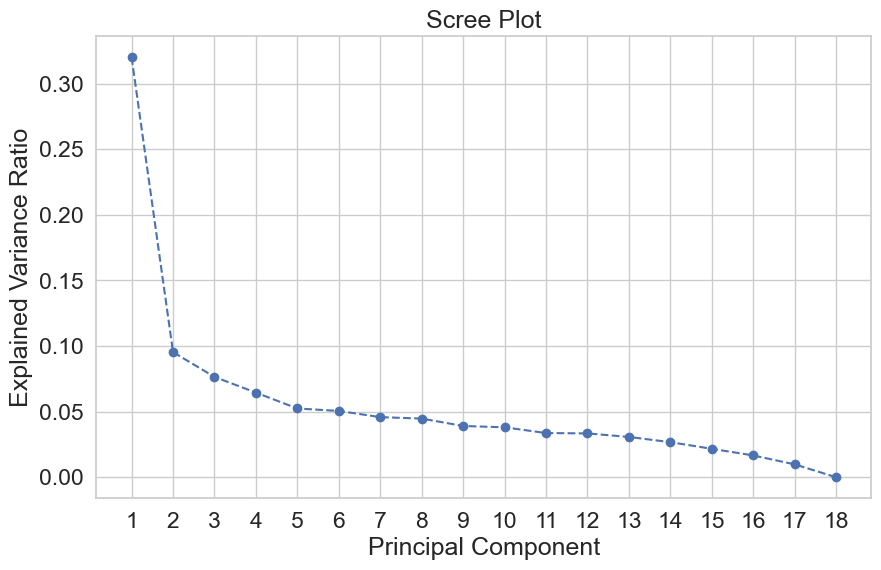

In [83]:
features = best_words + ["length_email", "num_words", "num_characters","html_tag_count"]
X2_train = train[features]
X2_val = val[features]
X2_test = test[features]


Y2_train = train["spam"]
Y2_val = val["spam"]
Y2_test = test["spam"]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X2_train)
val_scaled = scaler.transform(X2_val)
test_scaled = scaler.transform(X2_test)

# Fit PCA without limiting the number of components
pca = PCA()
pca.fit(train_scaled)

# Plotting the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

## Selecting the top 5 Principal Components to use in our classifier

In [84]:
# Apply PCA with the number of components determined by the scree plot (e.g., if elbow at 10 components)
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(train_scaled)
X_val_pca = pca.transform(val_scaled)
X_test_pca = pca.transform(test_scaled)

<br><br>

---

## Fitting the Model to our Training Feature Set 

In [85]:
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize import OptimizeWarning

# Suppress ConvergenceWarning and OptimizeWarning for simplicity
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", OptimizeWarning)

parameters = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga']}

lr_model = LogisticRegression()
grid = GridSearchCV(estimator=lr_model, param_grid=parameters)

grid_result = grid.fit(X2_train, Y2_train)

best_params = grid_result.best_params_

# Fit logistic regression on the PCA-transformed data
log_reg = LogisticRegression(**best_params, max_iter = 500)
log_reg.fit(X_train_pca, Y2_train)

/Users/bing/miniconda3/envs/UDUB/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bing/miniconda3/envs/UDUB/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bing/miniconda3/envs/UDUB/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bing/miniconda3/envs/UDUB/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/bing/miniconda3/envs/UDUB/lib/python3.12/site-packages/scipy/optimize

LogisticRegression(max_iter=500, solver='newton-cg')

### Training Predictions and Training Accuracy

In [86]:
len(Y2_test)

1065

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      4492
           1       0.85      0.67      0.75      1538

    accuracy                           0.88      6030
   macro avg       0.87      0.81      0.84      6030
weighted avg       0.88      0.88      0.88      6030

AUC Score: 0.9017799451589706
Optimal Threshold: 0.26748509550392746


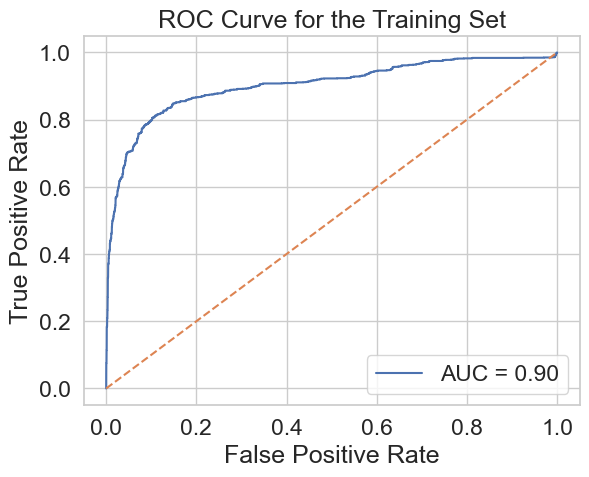

In [87]:
# Evaluate the model
y_pred = log_reg.predict(X_train_pca)
y_pred_prob = log_reg.predict_proba(X_train_pca)[:, 1]

print(classification_report(Y2_train, y_pred))
auc = roc_auc_score(Y2_train, y_pred_prob)
print("AUC Score:", auc)

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(Y2_train, y_pred_prob)

# Find the optimal threshold (for demonstration, we can use Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Training Set')
plt.legend(loc='lower right')
plt.show()

### Recall and Precision for the Training Set

In [88]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Assuming y_test are the true labels and y_pred are the predicted labels
report = classification_report(Y2_train, y_pred, output_dict=True)

# Extract precision and recall for each class
precision_ham = report['0']['precision']
recall_ham = report['0']['recall']

precision_spam = report['1']['precision']
recall_spam = report['1']['recall']

# Print precision and recall sentences
print(f"For ham (class 0):\nPrecision: {precision_ham:.2f}")
print(f"Out of all the emails predicted as ham, {precision_ham * 100:.0f}% were actually ham.")
print(f"Recall: {recall_ham:.2f}")
print(f"Out of all the actual ham emails, {recall_ham * 100:.0f}% were correctly identified.\n")

print(f"For spam (class 1):\nPrecision: {precision_spam:.2f}")
print(f"Out of all the emails predicted as spam, {precision_spam * 100:.0f}% were actually spam.")
print(f"Recall: {recall_spam:.2f}")
print(f"Out of all the actual spam emails, {recall_spam * 100:.0f}% were correctly identified.")

For ham (class 0):
Precision: 0.89
Out of all the emails predicted as ham, 89% were actually ham.
Recall: 0.96
Out of all the actual ham emails, 96% were correctly identified.

For spam (class 1):
Precision: 0.85
Out of all the emails predicted as spam, 85% were actually spam.
Recall: 0.67
Out of all the actual spam emails, 67% were correctly identified.


<br><br>

---

## Validation Predictions

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       919
           1       0.78      0.72      0.74       334

    accuracy                           0.87      1253
   macro avg       0.84      0.82      0.83      1253
weighted avg       0.87      0.87      0.87      1253

AUC Score: 0.9109485056003336
Optimal Threshold: 0.299924470543802


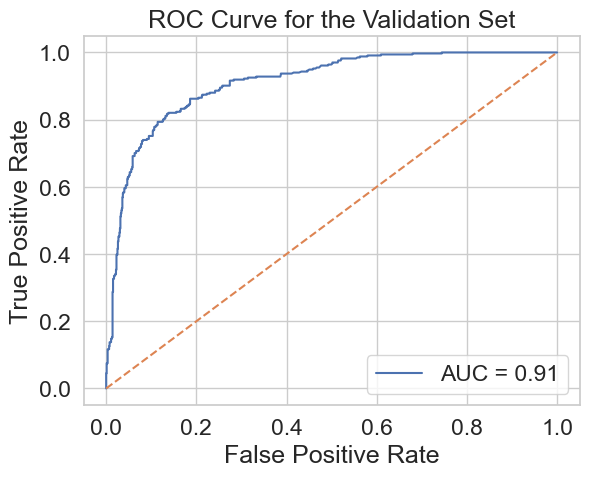

In [89]:
# Evaluate the model
y_pred = log_reg.predict(X_val_pca)
y_pred_prob = log_reg.predict_proba(X_val_pca)[:, 1]

print(classification_report(Y2_val, y_pred))
auc = roc_auc_score(Y2_val, y_pred_prob)
print("AUC Score:", auc)

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(Y2_val, y_pred_prob)

# Find the optimal threshold (for demonstration, we can use Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Validation Set')
plt.legend(loc='lower right')
plt.show()

In [90]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Assuming y_test are the true labels and y_pred are the predicted labels
report = classification_report(Y2_val, y_pred, output_dict=True)

# Extract precision and recall for each class
precision_ham = report['0']['precision']
recall_ham = report['0']['recall']

precision_spam = report['1']['precision']
recall_spam = report['1']['recall']

# Print precision and recall sentences
print(f"For ham (class 0):\nPrecision: {precision_ham:.2f}")
print(f"Out of all the emails predicted as ham, {precision_ham * 100:.0f}% were actually ham.")
print(f"Recall: {recall_ham:.2f}")
print(f"Out of all the actual ham emails, {recall_ham * 100:.0f}% were correctly identified.\n")

print(f"For spam (class 1):\nPrecision: {precision_spam:.2f}")
print(f"Out of all the emails predicted as spam, {precision_spam * 100:.0f}% were actually spam.")
print(f"Recall: {recall_spam:.2f}")
print(f"Out of all the actual spam emails, {recall_spam * 100:.0f}% were correctly identified.")

For ham (class 0):
Precision: 0.90
Out of all the emails predicted as ham, 90% were actually ham.
Recall: 0.92
Out of all the actual ham emails, 92% were correctly identified.

For spam (class 1):
Precision: 0.78
Out of all the emails predicted as spam, 78% were actually spam.
Recall: 0.72
Out of all the actual spam emails, 72% were correctly identified.


In [95]:
len(Y2_val)

1253

<br><br>

---

## Training Predictions

In [91]:
len(X_test_pca)

1065

In [92]:
len(Y2_test)

1065

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       797
           1       0.74      0.75      0.74       268

    accuracy                           0.87      1065
   macro avg       0.83      0.83      0.83      1065
weighted avg       0.87      0.87      0.87      1065

AUC Score: 0.9119623026648438
Optimal Threshold: 0.27822532264799327


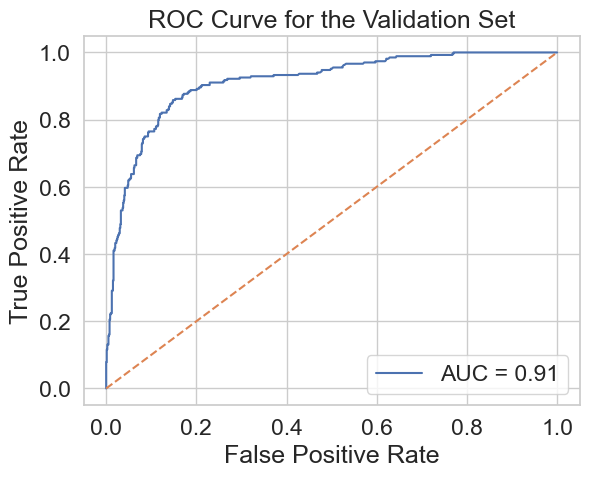

In [93]:
# Evaluate the model
y_pred = log_reg.predict(X_test_pca)
y_pred_prob = log_reg.predict_proba(X_test_pca)[:, 1]

print(classification_report(Y2_test, y_pred))
auc = roc_auc_score(Y2_test, y_pred_prob)
print("AUC Score:", auc)

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(Y2_test, y_pred_prob)

# Find the optimal threshold (for demonstration, we can use Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Validation Set')
plt.legend(loc='lower right')
plt.show()

In [94]:
from sklearn.metrics import classification_report, precision_score, recall_score

# Assuming y_test are the true labels and y_pred are the predicted labels
report = classification_report(Y2_test, y_pred, output_dict=True)

# Extract precision and recall for each class
precision_ham = report['0']['precision']
recall_ham = report['0']['recall']

precision_spam = report['1']['precision']
recall_spam = report['1']['recall']

# Print precision and recall sentences
print(f"For ham (class 0):\nPrecision: {precision_ham:.2f}")
print(f"Out of all the emails predicted as ham, {precision_ham * 100:.0f}% were actually ham.")
print(f"Recall: {recall_ham:.2f}")
print(f"Out of all the actual ham emails, {recall_ham * 100:.0f}% were correctly identified.\n")

print(f"For spam (class 1):\nPrecision: {precision_spam:.2f}")
print(f"Out of all the emails predicted as spam, {precision_spam * 100:.0f}% were actually spam.")
print(f"Recall: {recall_spam:.2f}")
print(f"Out of all the actual spam emails, {recall_spam * 100:.0f}% were correctly identified.")

For ham (class 0):
Precision: 0.92
Out of all the emails predicted as ham, 92% were actually ham.
Recall: 0.91
Out of all the actual ham emails, 91% were correctly identified.

For spam (class 1):
Precision: 0.74
Out of all the emails predicted as spam, 74% were actually spam.
Recall: 0.75
Out of all the actual spam emails, 75% were correctly identified.


<br/>
<hr style="border: 1px solid #fdb515;" />

# Analyzing The Model

<!-- BEGIN QUESTION -->

<br>

---

# How we improved the model

* Besides looking at how the accuracy changed with specific features, I also made use of some more EDA. In particular, I decided to keep adding more words to my heat map and look for the correlation between *that* specific feature and whether the email is spam or ham. 

* I decided in the end to add a bunch of words into my feature set, and then only keep the top 10 words which had the highest correlation with `is_spam`. 
* I also made use of specific features looking at total characters, total words, and specific characters like "<" or "!". The main thing I noticed, however, was that a lot of these features like "total characters" or "number of HTML" tags, while they did have *some* impact, they didn't have as much impact as changing the *specific* words. 
* I tried to favor specific **spam** words as my features. The specific feature of "receive", or the feature indicating if an email contained the word "receive," really surprised me. I didn't really associate this word as a **spammy** word, so it pleasantly surprised me when I saw its impact on the accuracy of the model. 